## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import glob
import os
from moviepy.editor import VideoFileClip

## Camera Calibration

This cell perfomes camera calibration using a certain number of calibration pictures of a chessboard, in order to obtain "mtx" - camera matrix - and "dist" - distortion coefficients - used to undistort raw pictures/video frame.

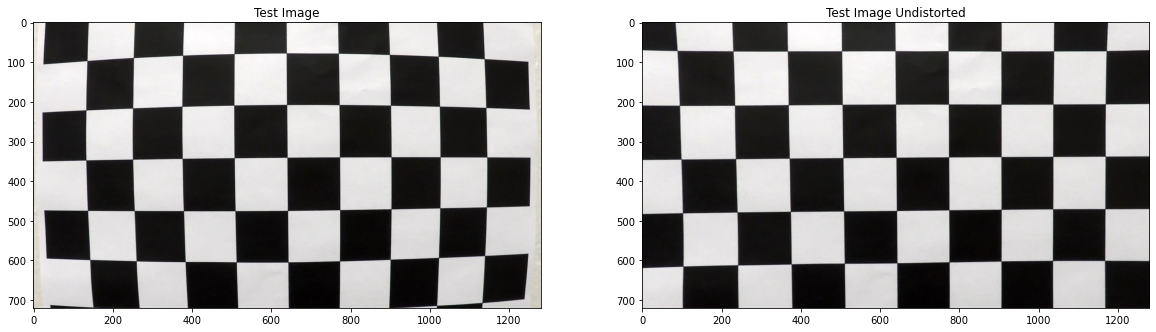

In [2]:
############### Camera calibration  ##################

# Path description for calibration images
path = os.getcwd()
cal_img_path = os.path.join(path,'camera_cal/')

# Cheesboard parameters
num_cornerx = 9
num_cornery = 6

# Object point array preparation
objp = np.zeros((num_cornery*num_cornerx,3), np.float32)
objp[:,:2] = np.mgrid[0:num_cornerx, 0:num_cornery].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# List of calibration images
images = glob.glob(cal_img_path + 'calibration*.jpg')

# Cache containing camera calibration parameter initialization
cache_cam_cal = {}

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    
    img = mpimg.imread(fname)
    img_size = (img.shape[1], img.shape[0])
    
    # Grayscale conversion (RGB2GRAY because I am using matplotlib.image.imread)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (num_cornerx,num_cornery), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

# Camera calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

# Camera calibration cache populated
cache_cam_cal["mtx"] = mtx
cache_cam_cal["dist"] = dist

# Undistortion function definition
def undistortion(img):
    
    dst = cv2.undistort(img, cache_cam_cal["mtx"], cache_cam_cal["dist"], None, cache_cam_cal["mtx"])
    
    return dst

# Sanity check for camera calibration
test_img = mpimg.imread(cal_img_path + 'calibration1.jpg')
test_dst = undistortion(test_img)

# Plot source (distorted) image and undistorted image as comparison
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Test Image')
ax1.imshow(test_img)
ax2.set_title('Test Image Undistorted')
ax2.imshow(test_dst)

## Function definition for the Pipeline - Thresholding and Combination

These functions apply different algorithms for lane recognition.
* Function "threshold()" is in charge of selecting the filter given by the user and relative thresholds, and call other functions - activate functions - (e.g. abs_sobel_threshold) in order to apply the filter
* Function "combine()" is used to combine the binary images resulting from each function activated. It returns the final output.

In [3]:
######### Thresholding & Combination #########

def abs_sobel_threshold(image, orient = 'x', sobel_kernel = 3, thresh = (0, 255)):
    
    min_th = thresh[0]
    max_th = thresh[1]
    
    # Calculate directional gradient
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        
    abs_sobel = np.absolute(sobel)
    
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Apply threshold
    
    grad_binary = np.zeros_like(scaled_sobel)
    
    grad_binary[(scaled_sobel >= min_th) & (scaled_sobel <= max_th)] = 1
    
    return grad_binary

def mag_threshold(image, sobel_kernel = 3, thresh = (0, 255)):
    
    min_th = thresh[0]
    max_th = thresh[1]
    
    # Calculate gradient magnitude
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    mag = np.sqrt(sobelx**2 + sobely**2)
    
    scaled_sobel = np.uint8(255*mag/np.max(mag))
    
    # Apply threshold
    
    mag_binary = np.zeros_like(scaled_sobel)
    
    mag_binary[(scaled_sobel >= min_th) & (scaled_sobel <= max_th)] = 1
    
    return mag_binary

def dir_threshold(image, sobel_kernel = 3, thresh = (0, np.pi/2)):
    
    min_th = thresh[0]
    max_th = thresh[1]
    
    # Calculate gradient direction
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    
    # Apply threshold
    
    dir_binary = np.zeros_like(grad_dir)
    
    dir_binary[(grad_dir >= min_th) & (grad_dir <= max_th)] = 1
    
    return dir_binary

def hls_threshold(image, hls_channel = 's', thresh = (0, 255)):
    
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    if hls_channel == 'h':
        channel = h_channel
        #print('Chosen h_channel')
    elif hls_channel == 'l':
        channel = l_channel
        #print('Chosen l_channel')
    elif hls_channel == 's':
        channel = s_channel
        #print('Chosen s_channel')
    
    hlsbinary = np.zeros_like(channel)
    hlsbinary[(channel >= thresh[0]) & (channel <= thresh[1])] = 1
    
    return hlsbinary

def color_threshold(image, color_channel = 'r', thresh = (0, 255)):
    
    r_channel = image[:,:,0]
    g_channel = image[:,:,1]
    b_channel = image[:,:,2]
    
    if color_channel == 'r':
        channel = r_channel
        #print('Chosen h_channel')
    elif color_channel == 'g':
        channel = g_channel
        #print('Chosen l_channel')
    elif color_channel == 'b':
        channel = b_channel
        #print('Chosen s_channel')
        
    colorbinary = np.zeros_like(channel)
    colorbinary[(channel >= thresh[0]) & (channel <= thresh[1])] = 1
    
    return colorbinary

def combine(results, comb = True):
    
    # results = [[gradx], [grady], [mag_binary], [dir_binary], [hls]]
    
    if len(results) == 1:
        
        combined = results[0]
    
    elif len(results) == 2:
        
        combined = np.zeros_like(results[0])
        
        if comb == True:
            combined[((results[0] == 1) | (results[1] == 1))] = 1
            
        else:
            combined[((results[0] == 1) & (results[1] == 1))] = 1
    
    elif len(results) == 4:
        
        combined = np.zeros_like(results[0])
        combined[((results[0] == 1) & (results[1] == 1)) | ((results[2] == 1) & (results[3] == 1))] = 1
    
    return combined


def threshold(image, algorithm, sx_ksize = 3, sx_thresh = (30, 100), 
              sy_ksize = 3, sy_thresh = (30, 100), 
              mag_ksize = 3, mag_thresh = (30, 100), 
              dir_ksize = 3, dir_thresh = (0.7, 1.3), 
              hls_channel = 's', hls_thresh = (170, 255),
              color_channel = 'r', color_thresh = (30, 100),
              comb = True):
    # sx Sobelx gradient, sy Sobely gradient, m Magnitude, d Direction Gradient

    results = []
    combination = []

    for i in range(len(algorithm)):

        if algorithm[i] == 'gradx':
            gradx = abs_sobel_threshold(image, orient = 'x', sobel_kernel = sx_ksize, thresh = sx_thresh)
            results.append(gradx)
            combination.append('gradx')
        elif algorithm[i] == 'grady':
            grady = abs_sobel_threshold(image, orient = 'y', sobel_kernel = sy_ksize, thresh = sy_thresh)
            results.append(grady)
            combination.append('grady')
        elif algorithm[i] == 'mag':
            mag_binary = mag_threshold(image, sobel_kernel = mag_ksize, thresh = mag_thresh)
            results.append(mag_binary)
            combination.append('mag')
        elif algorithm[i] == 'dir':
            dir_binary = dir_threshold(image, sobel_kernel = dir_ksize, thresh = dir_thresh)
            results.append(dir_binary)
            combination.append('dir')
        elif algorithm[i] == 'hls':
            hls_binary = hls_threshold(image, hls_channel = hls_channel, thresh = hls_thresh)
            results.append(hls_binary)
            combination.append('hls ' + hls_channel + '-channel')
        elif algorithm[i] == 'col':
            color_binary = color_threshold(image, color_channel = color_channel, thresh = color_thresh)
            results.append(color_binary)
            combination.append('color ' + channel + '-channel')    
        

        combined = combine(results, comb)
    
    return combined, combination

## Function definition for the Pipeline - Warping and Sliding Windows

"warping()" is used to obratin warped image (Perspective Transform) or reverse - depending on "direction" value: direction == 1 from unwarped to warped, direction == 0 from warped to unwarped

"find_lane_pixels()":
* apply histogram algorithm to the binary warped in order to find the lines starting point at coordinate ymax
* define windows parameters (#, margin, minpix, height)
* identify x and y coordinates of nonzero elements in the binary image
* set starting points of left and right windows
* iterate thought number of windows
* identify nonzero pixels (x & y coordinates) inside the windows
* adjust next windows position based on the minimum number of pixels identified in the previous

output: x & y coordinates of the pixels belonging to left and right line in the whole frame

In [4]:
def warping(image, vertices, direction):

    src = np.float32(vertices)

    dst = np.float32([[150, image.shape[0]],
            [150,0],
            [image.shape[1]-150,0],
            [image.shape[1]-150,image.shape[0]]])
    
    img_size = (image.shape[1], image.shape[0])
    
    M = cv2.getPerspectiveTransform(src, dst)
    
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    if direction == 1:
        m_fin = M
    else:
        m_fin = Minv

    warped = cv2.warpPerspective(image, m_fin, img_size, flags = cv2.INTER_LINEAR)
    
    return warped

def find_lane_pixels(binary_warped):
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    
    # y is [0] because y is vertical - rows, x is horizontal [1] - columns
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        
        # start from bottom line - binary_warped.shape[0] = ymax
        # since first value of window is 0, 0*window_height = 0, win_y_high = ymax
        # win_y_low = ymax-1*window_height
        
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        
        ### Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        ### Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### If you found > minpix pixels, recenter next window  ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fitx, right_fitx, ploty, left_fit, right_fit, failL, failR = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)

    return left_fitx, right_fitx, ploty, leftx, lefty, rightx, righty, left_fit, right_fit, failL, failR

def search_around_poly(binary_warped, left_fit_prev, right_fit_prev):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + 
                    left_fit_prev[2] - margin)) & (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + 
                    left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + 
                    right_fit_prev[2] - margin)) & (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + 
                    right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty, left_fit, right_fit, failL, failR = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)

    return left_fitx, right_fitx, ploty, leftx, lefty, rightx, righty, left_fit, right_fit, failL, failR

## Function Definition for the Pipeline - Fit_Polynomial and Curvature Measurement

* "fit_polynomial()" first fit a second order polynomial to the points identified (x & y for left and right line), then generates x & y coordinates for the lane drawing.

* "pixel_to_m()" transform pixel to meter

* "measure_curvature_pixels()" calculates the curvature radius (in pixels) of each identified line.

In [5]:
def pixel_to_m(ploty, lefty, leftx, righty, rightx):
    
    # Conversion pixel to meters    
    ym_per_pix = 30/720   # meters per pixel in y dimension
    xm_per_pix = 3.7/700  # meters per pixel in x dimension
    
    ploty_cr = ploty*ym_per_pix
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, deg = 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, deg = 2)   

    return ploty_cr, left_fit_cr, right_fit_cr


def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, deg = 2)
    right_fit = np.polyfit(righty, rightx, deg = 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    
    # left fit is empty
    if not left_fit.any:
        failL = 1
    else:
        failL = 0
    if not right_fit.any:
        failR = 1
    else:
        failR = 0
    
    ### Calc both polynomials using ploty, left_fit and right_fit ###
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    return left_fitx, right_fitx, ploty, left_fit, right_fit, failL, failR

def measure_curvature_pixels(ploty, left_fit, right_fit):
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = (1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**(3/2)/(np.absolute(2*left_fit[0]))  ## Implement the calculation of the left line here
    right_curverad = (1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**(3/2)/(np.absolute(2*right_fit[0]))  ## Implement the calculation of the right line here
    
    return left_curverad, right_curverad

In [6]:
# Define a class to receive the characteristics of each line detection
class Line:
    
    num_of_lines = 0
        
    def __init__(self, detected, recent_xfitted, current_fit, radius_of_curvature,
                line_base_pos, diffs, allx, ally):
        # was the line detected in the last iteration?
        self.detected = detected
        # x values of the last n fits of the line
        self.recent_xfitted = recent_xfitted
        #average x values of the fitted line over the last n iterations
        #self.bestx = self.bestx + recent_xfitted
        #polynomial coefficients for the most recent fit
        self.current_fit = current_fit
        #polynomial coefficients averaged over the last n iterations
        #self.best_fit = current_fit
        #radius of curvature of the line in some units
        self.radius_of_curvature = radius_of_curvature
        #distance in meters of vehicle center from the line
        self.line_base_pos = line_base_pos
        #difference in fit coefficients between last and new fits
        self.diffs = diffs
        #x values for detected line pixels
        self.allx = allx
        #y values for detected line pixels
        self.ally = ally
        
        
        
        Line.num_of_lines += 1
        
class LineL(Line):
    pass

class LineR(Line):
    pass

In [7]:
############### Pipeline test image ################## 

def process_img(image, vertices):

    img_size = (image.shape[1], image.shape[0])

########## Undistortion ###########

    undist = undistortion(image)
    
###### Perspective Transform ######

#    vertices = [[140, image.shape[0]],
#                [image.shape[1]/2-35,image.shape[0]/2+90],
#                [image.shape[1]/2+40,image.shape[0]/2+90],
#                [image.shape[1]-80,image.shape[0]]]

# direction = 1 bird-eye warping
    warped = warping(undist, vertices, direction = 1)

########## Thresholding ###########

    algorithm = ['gradx', 'hls']
    comb = True
    ksize = 3
    sx_thresh = (10, 100)
    sy_thresh = (80, 105)
    mag_thresh = (30, 100)
    dir_thresh = (2, 255)
    hls_thresh = (140, 255) #170-255
    hls_channel = 's'
    color_thresh = (80, 100)
    color_channel = 'r'


    combined, combination = threshold(warped, algorithm, 
                                      sx_thresh = sx_thresh, sy_thresh = sy_thresh, 
                                      mag_thresh = mag_thresh, dir_thresh = dir_thresh,
                                      hls_thresh = hls_thresh, hls_channel = hls_channel, 
                                      color_thresh = color_thresh, color_channel = color_channel,
                                      comb = comb)

############ Find Lines ############
########## Histogram Peaks #########
########## Sliding Windows #########

    ploty, left_fit, right_fit, left_fitx, right_fitx, ploty_cr, left_fit_cr, right_fit_cr = fit_polynomial(combined)

    warp_zero = np.zeros_like(combined).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = warping(color_warp, vertices, direction = 0) 

# Combine the result with the original image
    newresult = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

######## Curvature Radius #########

    left_curverad, right_curverad = measure_curvature_pixels(ploty_cr, left_fit_cr, right_fit_cr)
#
#
## Visualizing
#
#    #unwarped = warping(out_img, vertices, direction = 0)
#
#    #new_image = np.copy(image)
#    #new_image[unwarped == 1] = [255, 0, 0]
    
    return combined
    #return left_curverad, right_curverad, warped, newresult

In [ ]:
# Path description for test images
path = os.getcwd()
test_img_path = os.path.join(path,'test_images/')

# List of test images
images = os.listdir(test_img_path)
data_paths = [os.path.join(test_img_path, f) for f in images]

#for i in range(len(data_path))
image = mpimg.imread(data_paths[6])

vertices = [[140, image.shape[0]],
                [image.shape[1]/2-70,image.shape[0]/2+100],
                [image.shape[1]/2+77,image.shape[0]/2+100],
                [image.shape[1]-80,image.shape[0]]]

combined = process_img(image, vertices)
#left_curverad, right_curverad, warped, newresult = process_img(image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Test Image')

# vertices + lines ploted for visualization

cv2.line(image, (int(vertices[0][0]), int(vertices[0][1])), 
                 (int(vertices[1][0]), int(vertices[1][1])), color=[255, 0, 0], thickness = 2)

cv2.line(image, (int(vertices[1][0]), int(vertices[1][1])), 
                 (int(vertices[2][0]), int(vertices[2][1])), color=[255, 0, 0], thickness = 2)

cv2.line(image, (int(vertices[2][0]), int(vertices[2][1])), 
                 (int(vertices[3][0]), int(vertices[3][1])), color=[255, 0, 0], thickness = 2)

ax1.imshow(image)
#avg_rad = (left_curverad + right_curverad)/2

#text =  ('Curvature Radius in m = ' + str(format(avg_rad, '.2f')))
#cv2.putText(newresult, text, (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 2, cv2.LINE_AA) #, color[, thickness[, lineType[, bottomLeftOrigin]]])

ax2.imshow(combined)

#if len(combination) > 1:
#    ax3.set_title(combination[0] + ' & ' + combination[1] + ' Combination')
#    
#else:
#    ax3.set_title(combination[0])
#    
##plt.plot(left_fitx, ploty, color='yellow')
##plt.plot(right_fitx, ploty, color='yellow')
#
#ax3.set_title('Unwarped')
#ax3.imshow(out_img)

#print(left_curverad)
#print(right_curverad)

# Save converted images in folder "output_images"
#file_name = path + 'output_images/' + str(images[im])
#cv2.imwrite(file_name, lines_edges)

In [85]:
def processImage(image):

############### Pipeline test video ################## 
    
    n_line = 1
    
    n_avg = 5
    
    img_size = (image.shape[1], image.shape[0])

########## Undistortion ###########

    undist = undistortion(image)
    
###### Perspective Transform ######

    vertices = [[140, image.shape[0]],
                [image.shape[1]/2-70,image.shape[0]/2+100],
                [image.shape[1]/2+77,image.shape[0]/2+100],
                [image.shape[1]-80,image.shape[0]]]

# direction = 1 bird-eye warping
    warped = warping(undist, vertices, direction = 1)

########## Thresholding ###########

    algorithm = ['gradx', 'hls']
    comb = True
    ksize = 3
    sx_thresh = (10, 100)
    sy_thresh = (80, 105)
    mag_thresh = (30, 100)
    dir_thresh = (2, 255)
    hls_thresh = (140, 255) #170-255
    hls_channel = 's'
    color_thresh = (80, 100)
    color_channel = 'r'

    combined, _ = threshold(warped, algorithm, 
                                      sx_thresh = sx_thresh, sy_thresh = sy_thresh, 
                                      mag_thresh = mag_thresh, dir_thresh = dir_thresh,
                                      hls_thresh = hls_thresh, hls_channel = hls_channel, 
                                      color_thresh = color_thresh, color_channel = color_channel,
                                      comb = comb)

########### Find Lines ############


    if (len(lineL_list) >= n_line or len(lineR_list) >= n_line) and (lineL_list[len(lineL_list)-1].detected != False and lineR_list[len(lineR_list)-1].detected != False):
        
######## Search from Prior ########
        
        left_fitx, right_fitx, ploty, leftx, lefty, rightx, righty, left_fit, right_fit, failL, failR = search_around_poly(combined, lineL_list[len(lineL_list)-1].current_fit, lineR_list[len(lineR_list)-1].current_fit)
        
    else:
        
######### Histogram Peaks #########
######### Sliding Windows #########

        left_fitx, right_fitx, ploty, leftx, lefty, rightx, righty, left_fit, right_fit, failL, failR = find_lane_pixels(combined)

############ Averages #############

    if len(lineL_list) >= n_avg:
        bestxL = np.sum(line.recent_xfitted for line in lineL_list[len(lineL_list)-n_avg:len(lineL_list)])/n_avg
        best_fitL = np.sum(line.current_fit for line in lineL_list[len(lineL_list)-n_avg:len(lineL_list)])/n_avg
        bestxR = np.sum(line.recent_xfitted for line in lineR_list[len(lineR_list)-n_avg:len(lineR_list)])/n_avg
        best_fitR = np.sum(line.current_fit for line in lineR_list[len(lineR_list)-n_avg:len(lineR_list)])/n_avg
    
######## Curvature Radius #########

    ploty_cr, left_fit_cr, right_fit_cr = pixel_to_m(ploty, lefty, leftx, righty, rightx)

    left_curverad, right_curverad = measure_curvature_pixels(ploty_cr, left_fit_cr, right_fit_cr)
    
######### Line instance ###########

    if failL != 1:
        
        detected = True
        recent_xfitted = left_fitx
        current_fit = left_fit
        radius_of_curvature = left_curverad
        line_base_pos = None
        diffs = np.array([0,0,0], dtype='float') 
        allx = leftx
        ally = lefty
        
    else:
        
        ## was the line detected in the last iteration?
        detected = False  
        ## x values of the last n fits of the line
        recent_xfitted = [] 
        ##polynomial coefficients for the most recent fit
        current_fit = [np.array([False])]  
        ##radius of curvature of the line in some units
        radius_of_curvature = None 
        ##distance in meters of vehicle center from the line
        line_base_pos = None 
        ##difference in fit coefficients between last and new fits
        diffs = np.array([0,0,0], dtype='float') 
        ##x values for detected line pixels
        allx = None  
        ##y values for detected line pixels
        ally = None
        
    linel = LineL(detected, recent_xfitted, current_fit, radius_of_curvature,
                line_base_pos, diffs, allx, ally)
        
    lineL_list.append(linel)
    
    if failR != 1:
        
        detected = True
        recent_xfitted = right_fitx
        current_fit = right_fit 
        radius_of_curvature = right_curverad
        line_base_pos = None
        diffs = np.array([0,0,0], dtype='float') 
        allx = rightx
        ally = righty
        
    else:
        
        ## was the line detected in the last iteration?
        detected = False  
        ## x values of the last n fits of the line
        recent_xfitted = [] 
        ##polynomial coefficients for the most recent fit
        current_fit = [np.array([False])]  
        ##radius of curvature of the line in some units
        radius_of_curvature = None 
        ##distance in meters of vehicle center from the line
        line_base_pos = None 
        ##difference in fit coefficients between last and new fits
        diffs = np.array([0,0,0], dtype='float') 
        ##x values for detected line pixels
        allx = None  
        ##y values for detected line pixels
        ally = None
        
    liner = LineR(detected, recent_xfitted, current_fit, radius_of_curvature,
                line_base_pos, diffs, allx, ally)
    
    lineR_list.append(liner)

######## Visualization #########

    warp_zero = np.zeros_like(combined).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    try:
        fitting_left = bestxL
        fitting_right = bestxR
    except UnboundLocalError:
        fitting_left = left_fitx
        fitting_right = right_fitx
        
# Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([fitting_left, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([fitting_right, ploty])))])
    pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image

    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)

    newwarp = warping(color_warp, vertices, direction = 0) 

# Combine the result with the original image

    newresult = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    avg_rad = (left_curverad + right_curverad)/2

    text =  ('Curvature Radius in m = ' + str(format(avg_rad, '.2f')))
    cv2.putText(newresult, text, (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 2, cv2.LINE_AA)
     
    return newresult

In [87]:
white_output = 'output_videos/project_video.mp4'
lineL_list = []
lineR_list = []
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(processImage) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)


                                                            

                                                              
t:  10%|▉         | 122/1260 [00:24<01:41, 11.21it/s, now=None]

t:   5%|▍         | 62/1260 [13:14<01:51, 10.70it/s, now=None]
                                                            

                                                              
t:  10%|▉         | 122/1260 [00:24<01:41, 11.21it/s, now=None]

t:   5%|▍         | 62/1260 [13:14<01:51, 10.70it/s, now=None]


t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]


t:   0%|          | 3/1260 [00:00<01:12, 17.39it/s, now=None]

Moviepy - Building video output_videos/project_video.mp4.
Moviepy - Writing video output_videos/project_video.mp4






t:   0%|          | 5/1260 [00:00<01:20, 15.51it/s, now=None]


t:   1%|          | 7/1260 [00:00<01:24, 14.88it/s, now=None]


t:   1%|          | 9/1260 [00:00<01:26, 14.38it/s, now=None]


t:   1%|          | 11/1260 [00:00<01:29, 13.91it/s, now=None]


t:   1%|          | 13/1260 [00:00<01:31, 13.60it/s, now=None]


t:   1%|          | 15/1260 [00:01<01:32, 13.47it/s, now=None]


t:   1%|▏         | 17/1260 [00:01<01:31, 13.52it/s, now=None]


t:   2%|▏         | 19/1260 [00:01<01:31, 13.60it/s, now=None]


t:   2%|▏         | 21/1260 [00:01<01:32, 13.37it/s, now=None]


t:   2%|▏         | 23/1260 [00:01<01:33, 13.29it/s, now=None]


t:   2%|▏         | 25/1260 [00:01<01:37, 12.70it/s, now=None]


t:   2%|▏         | 27/1260 [00:02<01:36, 12.76it/s, now=None]


t:   2%|▏         | 29/1260 [00:02<01:34, 13.01it/s, now=None]


t:   2%|▏         | 31/1260 [00:02<01:32, 13.22it/s, now=None]


t:   3%|▎         | 33/1260 [00:02<01:32, 13.27it/s, now=None]


t:   3%|▎         | 35/12

t:  17%|█▋        | 212/1260 [00:19<01:57,  8.90it/s, now=None]


t:  17%|█▋        | 213/1260 [00:19<02:14,  7.80it/s, now=None]


t:  17%|█▋        | 214/1260 [00:19<02:27,  7.10it/s, now=None]


t:  17%|█▋        | 216/1260 [00:19<02:12,  7.88it/s, now=None]


t:  17%|█▋        | 217/1260 [00:19<02:05,  8.32it/s, now=None]


t:  17%|█▋        | 219/1260 [00:19<01:54,  9.07it/s, now=None]


t:  18%|█▊        | 221/1260 [00:20<01:47,  9.63it/s, now=None]


t:  18%|█▊        | 223/1260 [00:20<01:42, 10.13it/s, now=None]


t:  18%|█▊        | 225/1260 [00:20<01:39, 10.38it/s, now=None]


t:  18%|█▊        | 227/1260 [00:20<01:36, 10.70it/s, now=None]


t:  18%|█▊        | 229/1260 [00:20<01:34, 10.91it/s, now=None]


t:  18%|█▊        | 231/1260 [00:20<01:32, 11.11it/s, now=None]


t:  18%|█▊        | 233/1260 [00:21<01:32, 11.09it/s, now=None]


t:  19%|█▊        | 235/1260 [00:21<01:33, 10.97it/s, now=None]


t:  19%|█▉        | 237/1260 [00:21<01:33, 11.00it/s, now=None]


t:  19%|█▉

t:  32%|███▏      | 397/1260 [00:37<01:23, 10.32it/s, now=None]


t:  32%|███▏      | 399/1260 [00:37<01:22, 10.45it/s, now=None]


t:  32%|███▏      | 401/1260 [00:37<01:22, 10.42it/s, now=None]


t:  32%|███▏      | 403/1260 [00:37<01:20, 10.63it/s, now=None]


t:  32%|███▏      | 405/1260 [00:37<01:19, 10.72it/s, now=None]


t:  32%|███▏      | 407/1260 [00:38<01:19, 10.67it/s, now=None]


t:  32%|███▏      | 409/1260 [00:38<01:20, 10.60it/s, now=None]


t:  33%|███▎      | 411/1260 [00:38<01:19, 10.69it/s, now=None]


t:  33%|███▎      | 413/1260 [00:38<01:18, 10.81it/s, now=None]


t:  33%|███▎      | 415/1260 [00:38<01:17, 10.85it/s, now=None]


t:  33%|███▎      | 417/1260 [00:39<01:17, 10.87it/s, now=None]


t:  33%|███▎      | 419/1260 [00:39<01:22, 10.17it/s, now=None]


t:  33%|███▎      | 421/1260 [00:39<01:28,  9.47it/s, now=None]


t:  33%|███▎      | 422/1260 [00:39<01:33,  8.98it/s, now=None]


t:  34%|███▎      | 423/1260 [00:39<01:33,  8.93it/s, now=None]


t:  34%|██

t:  47%|████▋     | 591/1260 [00:56<01:20,  8.29it/s, now=None]


t:  47%|████▋     | 592/1260 [00:56<01:18,  8.49it/s, now=None]


t:  47%|████▋     | 594/1260 [00:56<01:14,  8.95it/s, now=None]


t:  47%|████▋     | 596/1260 [00:56<01:10,  9.38it/s, now=None]


t:  47%|████▋     | 598/1260 [00:56<01:08,  9.66it/s, now=None]


t:  48%|████▊     | 599/1260 [00:56<01:08,  9.63it/s, now=None]


t:  48%|████▊     | 600/1260 [00:57<01:09,  9.43it/s, now=None]


t:  48%|████▊     | 601/1260 [00:57<01:09,  9.46it/s, now=None]


t:  48%|████▊     | 602/1260 [00:57<01:09,  9.43it/s, now=None]


t:  48%|████▊     | 603/1260 [00:57<01:15,  8.72it/s, now=None]


t:  48%|████▊     | 605/1260 [00:57<01:12,  8.99it/s, now=None]


t:  48%|████▊     | 606/1260 [00:57<01:21,  8.01it/s, now=None]


t:  48%|████▊     | 607/1260 [00:57<01:24,  7.74it/s, now=None]


t:  48%|████▊     | 608/1260 [00:58<01:22,  7.87it/s, now=None]


t:  48%|████▊     | 609/1260 [00:58<01:18,  8.25it/s, now=None]


t:  48%|██

t:  56%|█████▌    | 706/1260 [01:11<01:13,  7.57it/s, now=None]


t:  56%|█████▌    | 707/1260 [01:11<01:12,  7.59it/s, now=None]


t:  56%|█████▌    | 708/1260 [01:11<01:12,  7.63it/s, now=None]


t:  56%|█████▋    | 709/1260 [01:11<01:14,  7.42it/s, now=None]


t:  56%|█████▋    | 710/1260 [01:11<01:15,  7.25it/s, now=None]


t:  56%|█████▋    | 711/1260 [01:11<01:12,  7.62it/s, now=None]


t:  57%|█████▋    | 712/1260 [01:11<01:07,  8.18it/s, now=None]


t:  57%|█████▋    | 713/1260 [01:12<01:08,  7.97it/s, now=None]


t:  57%|█████▋    | 714/1260 [01:12<01:10,  7.77it/s, now=None]


t:  57%|█████▋    | 715/1260 [01:12<01:10,  7.69it/s, now=None]


t:  57%|█████▋    | 716/1260 [01:12<01:08,  7.96it/s, now=None]


t:  57%|█████▋    | 717/1260 [01:12<01:04,  8.42it/s, now=None]


t:  57%|█████▋    | 718/1260 [01:12<01:05,  8.23it/s, now=None]


t:  57%|█████▋    | 719/1260 [01:12<01:06,  8.12it/s, now=None]


t:  57%|█████▋    | 720/1260 [01:12<01:08,  7.84it/s, now=None]


t:  57%|██

t:  70%|███████   | 886/1260 [01:29<00:43,  8.50it/s, now=None]


t:  70%|███████   | 887/1260 [01:29<00:44,  8.40it/s, now=None]


t:  70%|███████   | 888/1260 [01:29<00:43,  8.55it/s, now=None]


t:  71%|███████   | 889/1260 [01:29<00:43,  8.46it/s, now=None]


t:  71%|███████   | 890/1260 [01:29<00:44,  8.28it/s, now=None]


t:  71%|███████   | 891/1260 [01:29<00:45,  8.11it/s, now=None]


t:  71%|███████   | 892/1260 [01:30<00:45,  8.06it/s, now=None]


t:  71%|███████   | 893/1260 [01:30<00:45,  8.03it/s, now=None]


t:  71%|███████   | 894/1260 [01:30<00:45,  8.13it/s, now=None]


t:  71%|███████   | 895/1260 [01:30<00:45,  8.06it/s, now=None]


t:  71%|███████   | 896/1260 [01:30<00:45,  7.95it/s, now=None]


t:  71%|███████   | 897/1260 [01:30<00:43,  8.32it/s, now=None]


t:  71%|███████▏  | 898/1260 [01:30<00:41,  8.73it/s, now=None]


t:  71%|███████▏  | 899/1260 [01:30<00:40,  8.96it/s, now=None]


t:  71%|███████▏  | 900/1260 [01:30<00:39,  9.16it/s, now=None]


t:  72%|██

t:  82%|████████▏ | 1038/1260 [01:45<00:24,  9.06it/s, now=None]


t:  82%|████████▏ | 1039/1260 [01:45<00:24,  9.11it/s, now=None]


t:  83%|████████▎ | 1040/1260 [01:45<00:23,  9.36it/s, now=None]


t:  83%|████████▎ | 1041/1260 [01:45<00:23,  9.44it/s, now=None]


t:  83%|████████▎ | 1042/1260 [01:45<00:23,  9.39it/s, now=None]


t:  83%|████████▎ | 1043/1260 [01:46<00:23,  9.26it/s, now=None]


t:  83%|████████▎ | 1044/1260 [01:46<00:23,  9.28it/s, now=None]


t:  83%|████████▎ | 1045/1260 [01:46<00:22,  9.44it/s, now=None]


t:  83%|████████▎ | 1047/1260 [01:46<00:21,  9.97it/s, now=None]


t:  83%|████████▎ | 1049/1260 [01:46<00:20, 10.28it/s, now=None]


t:  83%|████████▎ | 1051/1260 [01:46<00:19, 10.47it/s, now=None]


t:  84%|████████▎ | 1053/1260 [01:46<00:19, 10.49it/s, now=None]


t:  84%|████████▎ | 1055/1260 [01:47<00:19, 10.53it/s, now=None]


t:  84%|████████▍ | 1057/1260 [01:47<00:19, 10.68it/s, now=None]


t:  84%|████████▍ | 1059/1260 [01:47<00:18, 10.81it/s, now=Non

t:  93%|█████████▎| 1176/1260 [02:00<00:09,  8.62it/s, now=None]


t:  93%|█████████▎| 1177/1260 [02:00<00:09,  8.74it/s, now=None]


t:  93%|█████████▎| 1178/1260 [02:00<00:09,  8.86it/s, now=None]


t:  94%|█████████▎| 1179/1260 [02:00<00:09,  8.86it/s, now=None]


t:  94%|█████████▎| 1180/1260 [02:00<00:08,  8.94it/s, now=None]


t:  94%|█████████▎| 1181/1260 [02:00<00:08,  8.96it/s, now=None]


t:  94%|█████████▍| 1182/1260 [02:00<00:09,  8.21it/s, now=None]


t:  94%|█████████▍| 1183/1260 [02:01<00:09,  7.94it/s, now=None]


t:  94%|█████████▍| 1184/1260 [02:01<00:09,  8.10it/s, now=None]


t:  94%|█████████▍| 1185/1260 [02:01<00:09,  8.22it/s, now=None]


t:  94%|█████████▍| 1186/1260 [02:01<00:08,  8.37it/s, now=None]


t:  94%|█████████▍| 1187/1260 [02:01<00:08,  8.26it/s, now=None]


t:  94%|█████████▍| 1188/1260 [02:01<00:08,  8.23it/s, now=None]


t:  94%|█████████▍| 1189/1260 [02:01<00:08,  8.23it/s, now=None]


t:  94%|█████████▍| 1190/1260 [02:01<00:08,  8.34it/s, now=Non

Moviepy - Done !
Moviepy - video ready output_videos/project_video.mp4
CPU times: user 7min 16s, sys: 54 s, total: 8min 10s
Wall time: 2min 10s


In [ ]:
#### classes ####

class Employee:
    
    #class variables
    num_of_emps = 0
    raise_amt = 1.04
    
    def __init__(self, first, last, pay):
        self.first = first
        self.last = last
        self.pay = pay
        self.email = first + '.' + last + '@gmail.com'
        self.count += pay
        
    def __repr__(self):
        # unambiguous representation of self object
        return "Employee('{}', '{}', '{}')".format(self.first, self.last, self.pay)
    
    def __str__(self):
        # readable representation of self object
        return '{} - {}'.format(self.fullname(), self.email)
    
        
   # everytime a instance is created (initialization) num_of_emps is incresed by 1 
        Employee.num_of_emps += 1
        
    def fullname(self):
        return '{} {}'.format(self.first, self.last)
    
    def apply_raise(self):
        self.pay = (self_pay * raise_amount)

        
    @classmethod
    def set_raise_amt(cls, amount):
        cls.raise_amt = amount
        
    @classmethod
    def from_string(cls, emp_str):
        first, last, pay = emp_str.split('-')
        return cls(first, last, pay)
    
#sub-class inheritance
class Developer(Employee):
    raise_amt = 1.10
    
    def __init__(self, first, last, pay, prog_lang):
        # inheritance from parent class
        super().__init__(first, last, pay)
        #otherwise, but less efficient
        #Employee.__init_(self, first, last, pay)
        self.prog_lang = prog_lang
    
class Manager(Employee):
    
    def __init__(self, first, last, pay, employees = None):
    # inheritance from parent class
        super().__init__(first, last, pay)
        if employees is None:
            self.employees = []
        else:
            self.employees = employees
        
    def add_emp(self, emp):
        if emp not in self.employees:
            self.employees.append(emp)
            
    def rmv_emp(self, emp):
        if emp in self.employees:
            self.employees.remove(emp)
            
    def print_emp(self):
        for emp in self.employees:
            print('-->', emp.fullname())
    

#instance variables
emp1 = Employee('Antonio', 'Caruso', 50000)
emp1_str = ('Alessia-Memeo-2')

# it creates attribute only for emp1 instance
emp1.raise_amount = 1.05
#print(Employee.__dict__)

new_emp1 = Employee.from_string(emp1_str)
dev1 = Developer('Antonio','Caruso', 40000, 'Python')

mgr1 = Manager('Alessia', 'Memeo', 90000, [dev1])


mgr1.print_emp()

#print(isinstance(mgr1, Manager))
#print(issubclass(Developer, Manager))


print(emp1)
print(repr(emp1))
print(str(emp1))
print(emp1.__repr__())
print(emp1.__str__())

    